# Neural Network for Binary Classification

Below, I will be training a binary classifier using pytorch. This is a simple example where I train a model to distinguish between an image of a 9 and an image of a 4. Several different variations of a 2 layer network are trained over 80 epochs, I have mainly varied how the weights for the neural network have been initialised by utilising different gaussian distributions.

I have also explored the effect of a differing number of neurons in the hidden layer on the classification accuracy of the model.

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
import scipy.io as sio
test_x = sio.loadmat('test_x_v7.mat')
test_y = sio.loadmat('test_y_v7.mat')
train_x = sio.loadmat('train_x_v7.mat')
train_y = sio.loadmat('train_y_v7.mat')

In [3]:
test_x = torch.from_numpy(test_x['test_x'].T)
test_y = torch.from_numpy(test_y['test_y'])
train_x = torch.from_numpy(train_x['train_x'].T)
train_y = torch.from_numpy(train_y['train_y'])

### Creating my Neural Network Class

In [4]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, input_size ,hidden_neurons, output_size, mean = None, std = None, weights_init = False):
        super(NeuralNetwork,self).__init__()
        
        if weights_init is True:
            
            #Defining the parameters of my neural network
            self.linfunc1 = nn.Linear(input_size, hidden_neurons)
            self.linfunc2 = nn.Linear(hidden_neurons, output_size)
            self.sigmoid_act_func = nn.Sigmoid()


            self.linfunc1.weight.data = torch.empty(input_size, hidden_neurons).normal_(mean=mean[0],std=std[0]).T
            self.linfunc2.weight.data = torch.empty(hidden_neurons, output_size).normal_(mean=mean[1],std=std[1]).T
            self.linfunc1.bias.data = torch.empty(hidden_neurons).normal_(mean=mean[2],std=std[2])
            self.linfunc2.bias.data = torch.empty(output_size).normal_(mean=mean[3],std=std[3])
            
        else:
            
            #Defining the parameters of my neural network
            self.linfunc1 = nn.Linear(input_size, hidden_neurons)
            self.linfunc2 = nn.Linear(hidden_neurons, output_size)
            self.sigmoid_act_func = nn.Sigmoid()
            
    
    def forward(self,inputs):
        output = self.linfunc2(self.sigmoid_act_func(self.linfunc1(inputs)))
        return output
            

## Creating my Training and Evaluation Functions

Below is the data used for training and testing the model

In [5]:
inputs = [train_x.float(), test_x.float()]
targets = [train_y.float(), test_y.float()]

In [6]:
def classification_accuracy(true_labels, recovered_labels):
    equal_labels = (recovered_labels == true_labels)
    return np.mean(equal_labels)

In [7]:
def classification_accuracy_for_train(network, data, true_labels):
    net = network
    net.eval()
    recovered_labels = np.where(net(data) > 0.5,1,0)
    equal_labels = (recovered_labels == true_labels)
    return np.mean(equal_labels)

In [8]:
def train(inputs, targets, network, optimiser, loss_function, \
          number_of_epochs = 80, print_output = 1):
    
    ''' INPUTS AND TARGETS TAKE IN LISTS AS ARGUMENTS. THE FIRST ITEM IS THE TRAIN SET,
    THE SECOND IS THE TEST SET
    '''
    
    criterion = loss_function
    optims = optimiser(network.parameters(), lr=0.1)
    
    running_loss = [] 
    testset_loss = []
    
    train_accuracy = []
    test_accuracy = []
    
    for counter in range(number_of_epochs):
        #Cloning network
        net_clone = network
        net_clone.eval()
        
        #zeroing the gradient
        optims.zero_grad()
        
        #Compute model predictions and loss values
        outputs = network(inputs[0])
        test_outputs = net_clone(inputs[1])
        
        loss = criterion(outputs, targets[0])
        test_loss = criterion(test_outputs, targets[1])
        
        running_loss.append(loss.item())
        testset_loss.append(test_loss.item())
        
        #Accuracy ...
        
        train_acc = classification_accuracy_for_train(network, inputs[0], targets[0].numpy())
        test_acc = classification_accuracy_for_train(network, inputs[1], targets[1].numpy())
        
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        
        #Perform backward pass and a gradient update step
        loss.backward()
        optims.step()
        
        if (counter + 1) % print_output == 0: 
            print('Epoch [%d/%d], Loss: %.4f' 
                   %(counter + 1, number_of_epochs, running_loss[counter]))

    print('Epoch [%d/%d] completed, Loss: %.4f' 
                   %(counter + 1, number_of_epochs, running_loss[counter]))
    
    #putting network into its evaluation mode ...
    
    network.eval()
    
    return network, running_loss, testset_loss, train_accuracy, test_accuracy

Setting the seed ...

In [9]:
torch.manual_seed(20)

## Task 1: Initialising weights and biases with random normal distribution

In [10]:
neurons = 8
input_dim = 784
output_dim = 1

#RANDOM NORMAL INITIALISATION

Net1 = NeuralNetwork(input_dim, neurons, output_dim, mean = [0,0,0,0], std = [1,1,1,1], weights_init = True)


#### Training my network ...

In [11]:
Net1, Net1_loss, Net1_test_loss, Net1_train_acc, Net1_test_acc = train(inputs, targets, network = Net1, optimiser = optim.SGD,\
                        loss_function = nn.MSELoss(),print_output = 20 )

Epoch [20/80], Loss: 0.5995
Epoch [40/80], Loss: 0.3905
Epoch [60/80], Loss: 0.3048
Epoch [80/80], Loss: 0.2612
Epoch [80/80] completed, Loss: 0.2612


#### Accuracy of Model 1 - N(0,1) initialisation ...

In [12]:
predictions = Net1(train_x.float())
predictions = np.where(predictions > 0.5, 1,0)
true_labels = train_y.numpy()

In [13]:
print("The classification accuracy for the training set is {p} %.".format(p = 100 * \
        classification_accuracy(true_labels, predictions)))

The classification accuracy for the training set is 68.359375 %.


In [14]:
test_predictions = Net1(test_x.float())
test_predictions = np.where(test_predictions > 0.5, 1,0)
true_test_labels = test_y.numpy()

In [15]:
print("The classification accuracy for the test set is {p} %.".format(p = 100 * \
        classification_accuracy(true_test_labels, test_predictions)))

The classification accuracy for the test set is 60.15625 %.


## Task 2 and 3: Creating plots for Error and Accuracy

In [16]:
def test_train_visualise(train_loss, test_loss):
    plot_fontsize = 14
    epochs = np.arange(len(train_loss))
    plt.plot(epochs, train_loss, label = 'Training Error', c = 'k')
    plt.plot(epochs, test_loss, label = 'Test Error', c = 'red')
    plt.xlabel('Number of Epochs', fontsize = plot_fontsize)
    plt.ylabel('Error', fontsize = plot_fontsize)
    #plt.title('N(0,1) initialised weights, 1 Hidden Layer, 8 Neurons')
    plt.legend(loc = 'best', fontsize = plot_fontsize)
    plt.show()

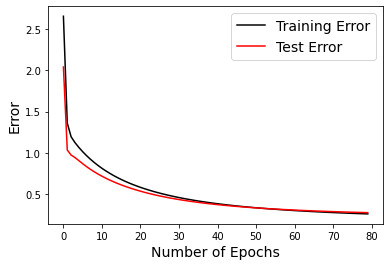

In [17]:
test_train_visualise(Net1_loss, Net1_test_loss)

In [18]:
def test_train_acc_visualise(train_acc, test_acc):
    plot_fontsize = 14
    epochs = np.arange(len(train_acc))
    plt.plot(epochs, train_acc, label = 'Training Accuracy', c = 'k')
    plt.plot(epochs, test_acc, label = 'Test Accuracy', c = 'red')
    plt.xlabel('Number of Epochs', fontsize = plot_fontsize)
    plt.ylabel('Accuracy', fontsize = plot_fontsize)
    #plt.title('N(0,1) initialised weights, 1 Hidden Layer, 8 Neurons')
    plt.legend(loc = 'best', fontsize = plot_fontsize)
    plt.show()
    

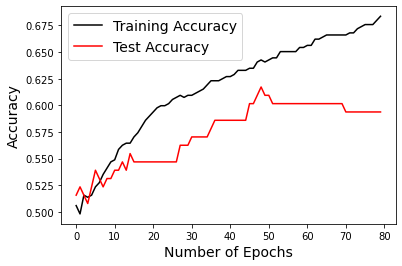

In [19]:
test_train_acc_visualise(Net1_train_acc,Net1_test_acc)

In [20]:
from sklearn import metrics

In [21]:
conf_mat_net1 = metrics.confusion_matrix(true_test_labels, test_predictions)
print('The confusion matrix for Net1 is as follows: {conf}'.format(conf = conf_mat_net1))

The confusion matrix for Net1 is as follows: [[48 16]
 [35 29]]


## Task 4: Initialise weights with customised distributions

In [22]:
#CUSTOM NORMAL INITIALISATION

Net3 = NeuralNetwork(input_dim, neurons, output_dim, mean = [0,0,0,0],\
                     std = [1/28, 1/np.sqrt(8), 1/28, 1/np.sqrt(8)], weights_init = True)

In [23]:
Net3, Net3_loss, Net3_test_loss,Net3_train_acc, Net3_test_acc = train(inputs, targets, network = Net3, optimiser = optim.SGD, \
             loss_function = nn.MSELoss(), print_output = 20)

Epoch [20/80], Loss: 0.1375
Epoch [40/80], Loss: 0.0825
Epoch [60/80], Loss: 0.0599
Epoch [80/80], Loss: 0.0511
Epoch [80/80] completed, Loss: 0.0511


#### Accuracy of Model 3 - Custom weights initialisation ...

In [24]:
predictions = Net3(train_x.float())
predictions = np.where(predictions > 0.5, 1,0)
true_labels = train_y.numpy()

In [25]:
print("The classification accuracy for the training set is {p} %.".format(p = 100 * \
        classification_accuracy(true_labels, predictions)))

The classification accuracy for the training set is 96.484375 %.


In [26]:
test_predictions = Net3(test_x.float())
test_predictions = np.where(test_predictions > 0.5, 1,0)
true_test_labels = test_y.numpy()

In [27]:
print("The classification accuracy for the test set is {p} %.".format(p = 100 * \
        classification_accuracy(true_test_labels, test_predictions)))

The classification accuracy for the test set is 95.3125 %.


Error for the training set and the test set ...

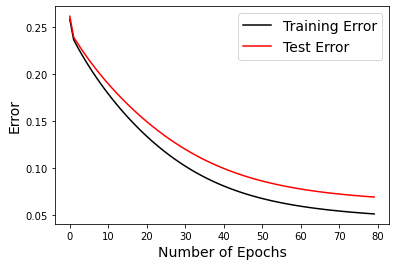

In [28]:
test_train_visualise(Net3_loss, Net3_test_loss)

Lets have a look at the accuracy of the training/testing set ...

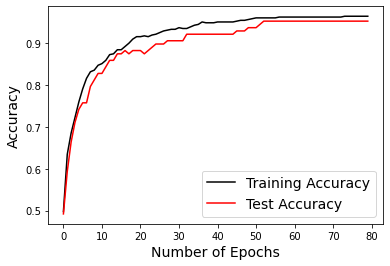

In [29]:
test_train_acc_visualise(Net3_train_acc, Net3_test_acc)

We achieve a 95.3% accuracy on our test set with this model after 80 epochs. Net1, which was initialised with weights which had an N(0,1) distribution gave a substantially less accuracy score of 60.2%. We may have had to train the model for much longer than 80 epochs in order to achieve similar accuracy values to Net3.

However, this may not be the case as the training/testing error graph from  Task 1, suggests that the error had plateaued at a value of around 0.26, whereas Net3's error plateaus at around 0.05. This implies that the intialisation of the weights in Task 1, siginificantly impacts the ability for the neural network to classify correctly.

We can further plot a confusion matrix to assess the performance of our model. 

In [30]:
conf_mat_net3 = metrics.confusion_matrix(true_test_labels, test_predictions)
print('The confusion matrix for Net3 is as follows: {conf}'.format(conf = conf_mat_net3))

The confusion matrix for Net3 is as follows: [[63  1]
 [ 5 59]]


We can see that the diagonal for the confusion matrix, which detects the true positives and true negatives are much greater than the opposite diagonal which detects the false positives (Type 1 error) and false negatives (Type 2 error). This suggests that our neural network classifies well.

If we compare this matrix to the confusion matrix generated by Net1, we see that the numbers are more evenly spread across the matrix, we have a much higher occurence of false negatives and false positives in this model.

However, what is interesting is that both models have more occurences where the image is a 4, but the model predicts this to be a 9. We can see this by the bottom left number being higher than the top right number in both cases.

In [31]:
conf_mat_net1

array([[48, 16],
       [35, 29]], dtype=int64)

## Task 5: Experimenting with different numbers of neurons in hidden layer

In [32]:
#CUSTOM HIDDEN NEURON DIMENSIONS
Net4_4n = 0
Net4_12n = 0
Net4_16n = 0
Net4_24n = 0
Net4_32n = 0
Net4_46n = 0
Net4_72n = 0


neurons = [4,12,16,24,32,46,72]
Nets = [Net4_4n, Net4_12n, Net4_16n, Net4_24n, Net4_32n, Net4_46n, Net4_72n]

for i in range(len(Nets)):
    
    #Creating the Neural Networks with the different numbers of neurons ... 
    
    Nets[i]= NeuralNetwork(input_dim, neurons[i], output_dim, mean = [0,0,0,0],\
                         std = [1/28, 1/np.sqrt(8), 1/28, 1/np.sqrt(8)], weights_init = True)


In [33]:
for i in range(len(Nets)):
    
    print('This iteration is for a NN with {n} neurons'.format(n = neurons[i]))

    Nets[i],_,_,_,_= train(inputs, targets, network = Nets[i], \
                    optimiser = optim.SGD, loss_function = nn.MSELoss(), print_output = 20)

This iteration is for a NN with 4 neurons
Epoch [20/80], Loss: 0.2459
Epoch [40/80], Loss: 0.2370
Epoch [60/80], Loss: 0.2162
Epoch [80/80], Loss: 0.1789
Epoch [80/80] completed, Loss: 0.1789
This iteration is for a NN with 12 neurons
Epoch [20/80], Loss: 0.1088
Epoch [40/80], Loss: 0.0644
Epoch [60/80], Loss: 0.0522
Epoch [80/80], Loss: 0.0475
Epoch [80/80] completed, Loss: 0.0475
This iteration is for a NN with 16 neurons
Epoch [20/80], Loss: 0.1430
Epoch [40/80], Loss: 0.0858
Epoch [60/80], Loss: 0.0625
Epoch [80/80], Loss: 0.0530
Epoch [80/80] completed, Loss: 0.0530
This iteration is for a NN with 24 neurons
Epoch [20/80], Loss: 0.2226
Epoch [40/80], Loss: 0.1944
Epoch [60/80], Loss: 0.1510
Epoch [80/80], Loss: 0.1040
Epoch [80/80] completed, Loss: 0.1040
This iteration is for a NN with 32 neurons
Epoch [20/80], Loss: 0.2139
Epoch [40/80], Loss: 0.1554
Epoch [60/80], Loss: 0.0959
Epoch [80/80], Loss: 0.0694
Epoch [80/80] completed, Loss: 0.0694
This iteration is for a NN with 46 n

#### Accuracy of Model 4 - Custom Hidden Neuron Dims ...

In [34]:
Net4_train_acc = []
for i in range(len(Nets)):
    predictions = Nets[i](train_x.float())
    predictions = np.where(predictions > 0.5, 1,0)
    true_labels = train_y.numpy()
    acc = 100 * classification_accuracy(true_labels, predictions)
    Net4_train_acc.append(acc)
    
    print("With {n} neurons, the classification accuracy for the training set is {p} %.".format(n = neurons[i],p = 100 * \
        classification_accuracy(true_labels, predictions)))

With 4 neurons, the classification accuracy for the training set is 90.234375 %.
With 12 neurons, the classification accuracy for the training set is 97.0703125 %.
With 16 neurons, the classification accuracy for the training set is 96.484375 %.
With 24 neurons, the classification accuracy for the training set is 91.796875 %.
With 32 neurons, the classification accuracy for the training set is 94.53125 %.
With 46 neurons, the classification accuracy for the training set is 64.2578125 %.
With 72 neurons, the classification accuracy for the training set is 53.7109375 %.


In [35]:
Net4_test_acc = []
for i in range(len(Nets)):
    predictions = Nets[i](test_x.float())
    predictions = np.where(predictions > 0.5, 1,0)
    true_labels = test_y.numpy()
    acc = 100 * classification_accuracy(true_labels, predictions)
    Net4_test_acc.append(acc)
    
    print("With {n} neurons, the classification accuracy for the test set is {p} %.".format(n = neurons[i],p = 100 * \
        classification_accuracy(true_labels, predictions)))
    

With 4 neurons, the classification accuracy for the test set is 87.5 %.
With 12 neurons, the classification accuracy for the test set is 93.75 %.
With 16 neurons, the classification accuracy for the test set is 94.53125 %.
With 24 neurons, the classification accuracy for the test set is 89.0625 %.
With 32 neurons, the classification accuracy for the test set is 92.96875 %.
With 46 neurons, the classification accuracy for the test set is 66.40625 %.
With 72 neurons, the classification accuracy for the test set is 51.5625 %.


I have tested 7 different values for the number of neurons in the hidden layer of the Neural Network. Lets plot the accuracy and see the best number of neurons.

In [36]:
def test_train_acc_visualise_1(train_acc, test_acc, x_values):
    plot_fontsize = 14
    plt.plot(x_values, train_acc, label = 'Training Accuracy', c = 'k')
    plt.plot(x_values, test_acc, label = 'Test Accuracy', c = 'red')
    plt.xlabel('Neurons in the Hidden Layer', fontsize = plot_fontsize)
    plt.ylabel('Accuracy', fontsize = plot_fontsize)
    #plt.title('N(0,1) initialised weights, 1 Hidden Layer, 8 Neurons')
    plt.legend(loc = 'best', fontsize = plot_fontsize)
    plt.show()

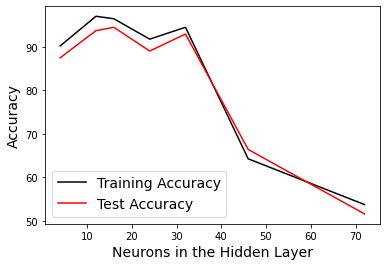

In [37]:
test_train_acc_visualise_1(Net4_train_acc,Net4_test_acc, neurons)

As we can see from the graph above, the accuracy peaks between 10-20 neurons in the hidden layer. After 32 layers, the performance very quickly tails off, to the point that the accuracy is even less than Net1.